# Problem 

A worldwide e-commerce site has localized versions of the site in Spanish. Managers noticed that Spain-based users have a much higher conversion rate than any other Spanish-speaking country. After talking to the international team in charge of Spain And Latin America(LatAm) about it, the Spain and LatAm country manager suggested that one reason could be translation. All Spanish- speaking countries originally had the same translation of the site which was written by a translator from Spain. 


# Proposed Solution

They agreed to try a test where each country would have its one translation written by a local (Argentinian users would see a translation written by an Argentinian, Mexican users by a Mexican, and so on), replicating what happened with Spanish users. As for users from Spain, they would have no change since their translation is already localized to Spanish.


## Hypothesis

Including a localized Spanish translation for each country's dialect will increase conversions for Spanish-speaking countries other than Spain.

## Metric

We will be using conversion as the metric to test our hypothesis.

##  Experiment



Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better Explain why that might be happening. Are the localized translations really worse? If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.

# write-up (most important) (after explore)
introduce the problem. Create a story around the dataset

# visualization and exploration
# stat test (2-tail test then power test) 
make sure I'm asking the correct questions (after testing), relevant to the proposed experiment.


In [2]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd
import re
import seaborn as sns
from scipy import stats

import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv(r"C:\Users\Mohammad\Documents\Thinkful\13.10 Capstone 2  - narrative analytics and experimentation\spanish_translation\test_table.csv")
df.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,12/3/2015,Direct,Web,ES,NaN,IE,1,0
1,497851,12/4/2015,Ads,Web,ES,Google,IE,0,1
2,848402,12/4/2015,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,12/3/2015,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,11/30/2015,Ads,Web,ES,Google,FireFox,0,1


In [4]:
users = pd.read_csv(r"C:\Users\Mohammad\Documents\Thinkful\13.10 Capstone 2  - narrative analytics and experimentation\spanish_translation\user_table.csv")
users.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [5]:
data = pd.merge(df, users , how='inner', on="user_id")
del df
del users
data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,12/3/2015,Direct,Web,ES,NaN,IE,1,0,M,32,Spain
1,497851,12/4/2015,Ads,Web,ES,Google,IE,0,1,M,21,Mexico
2,848402,12/4/2015,Ads,Web,ES,Facebook,Chrome,0,0,M,34,Spain
3,290051,12/3/2015,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22,Mexico
4,548435,11/30/2015,Ads,Web,ES,Google,FireFox,0,1,M,19,Mexico


Now that we have our dataframe ready, let us see the sizes of observations in control (test = 0) and treatment (test = 1) groups per country:

In [29]:
sample_sizes = data[['country','test','conversion']].groupby(['country','test']).count()
conversions = data[['country','test','conversion']].groupby(['country','test']).sum()
summary = pd.merge(sample_sizes,conversions,on=['country','test'])
summary = summary.rename(columns={'conversion_x':'sample_size','conversion_y':'conversion'})
summary['conv_ratio'] = summary['conversion']/summary['sample_size']
summary

sample_size  conversion  conv_ratio
country     test                                     
Argentina   0            9356         141    0.015071
            1           37377         513    0.013725
Bolivia     0            5550         274    0.049369
            1            5574         267    0.047901
Chile       0            9853         474    0.048107
            1            9884         507    0.051295
Colombia    0           27088        1411    0.052089
            1           26972        1364    0.050571
Costa Rica  0            2660         139    0.052256
            1            2649         145    0.054738
Ecuador     0            8036         395    0.049154
            1            7859         385    0.048988
El Salvador 0            4108         220    0.053554
            1            4067         195    0.047947
Guatemala   0            7622         386    0.050643
            1            7503         365    0.048647
Honduras    0            4361         222    0.050906
            1            4207         200    0.047540
Mexico      0           64209        3178    0.049495
            1           64275        3290    0.051186
Nicaragua   0            3419         180    0.052647
            1            3304         179    0.054177
Panama      0            1966          92    0.046796
            1            1985          98    0.049370
Paraguay    0            3650         177    0.048493
            1            3697         182    0.049229
Peru        0           16869         842    0.049914
            1           16797         850    0.050604
Spain       0           51782        4128    0.079719
Uruguay     0             415           5    0.012048
            1            3719          48    0.012907
Venezuela   0           16149         813    0.050344
            1           15905         779    0.048978

Control and treament groups generally seem to be balanced in all countries except Argentina and Uruguay. How much does data from these countries represent of the whole dataset?

In [23]:
Arg_Uru = (len(data[data['country']=='Argentina'])+len(data[data['country']=='Uruguay']))/len(data)*100
print(str(round(Arg_Uru,2))+'%')

11.23%


Alright, so 11% of a huge dataset can contain many conversions in one group or the other, biasing our results. However, many other countries have larger sample sizes that help converge to a normal probability, especially that we are testing for Spanish-speaking countries in general, and the majority of them are more closely balanced.

In [21]:
b = data[data['country']=='Uruguay']
len(b[b['conversion']==1])


53

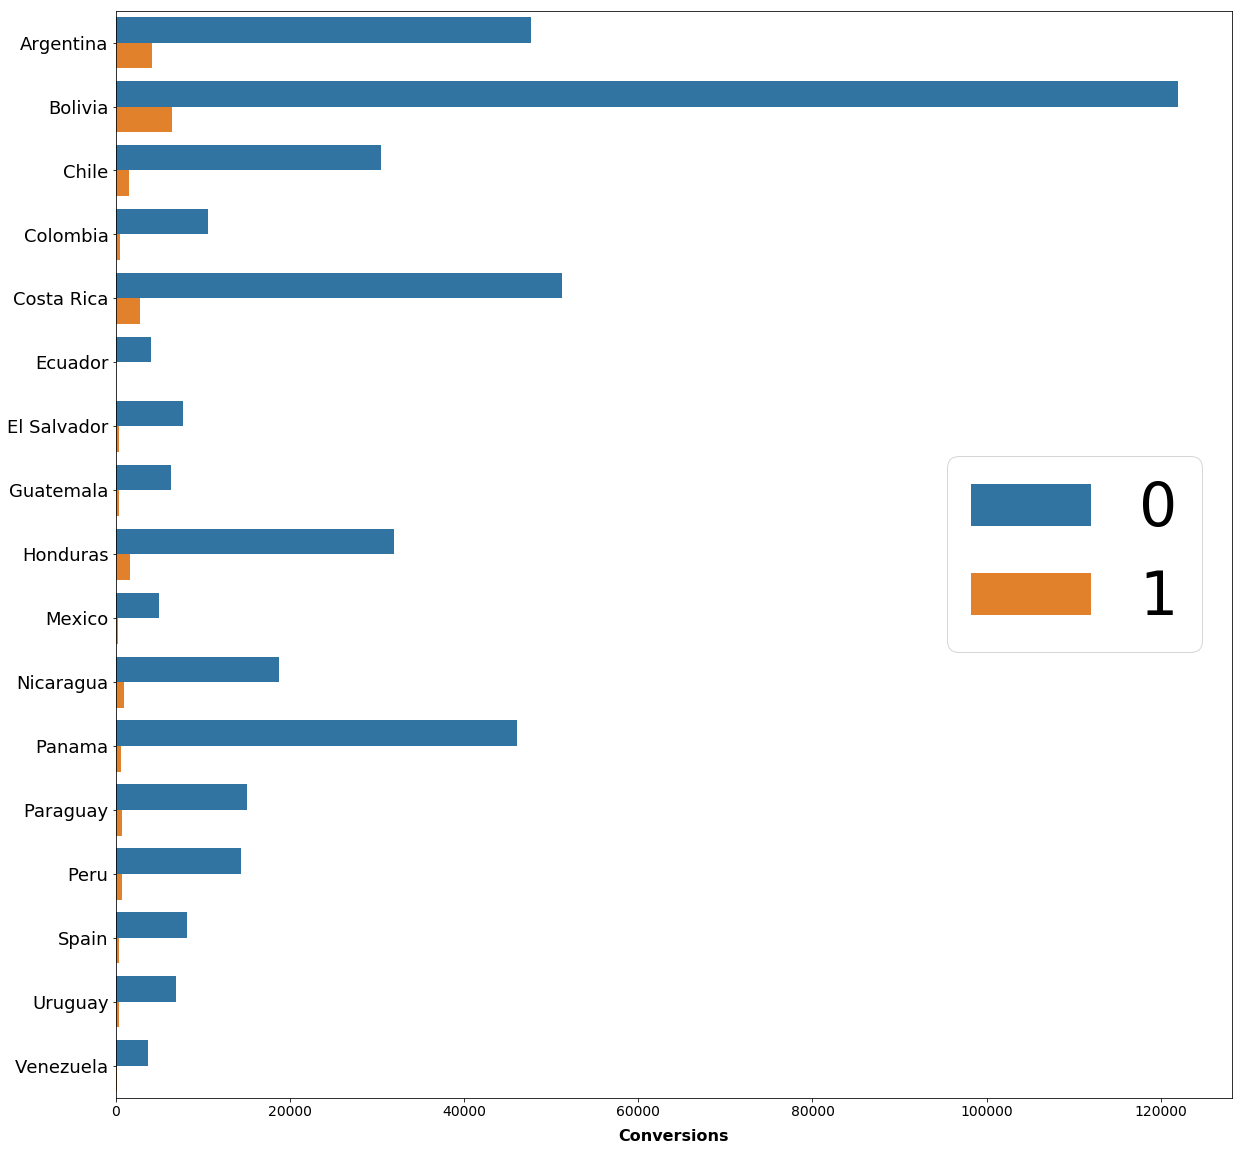

In [17]:
a = data[['country','test','conversion']]
a['conversion'] = [np.str(i) for i in a['conversion']]
#_____________________________________________
# Function that define how delays are grouped
exp_groups = np.unique(data["test"])
#____________________________________________________
fig = plt.figure(1, figsize=(20,20))
ax = sns.countplot(y="country", hue='conversion', data=a)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = np.unique(data['country'])
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=14, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=18, weight = 'normal', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Conversions', fontsize=16, weight = 'bold', labelpad=10)
#________________
# Set the legend
legend = plt.legend(loc='center right',prop={'size': 60})
# legend.get_texts()[0].set_text('on time (t < 5 min)')
# legend.get_texts()[1].set_text('small delay (5 < t < 45 min)')
plt.show()

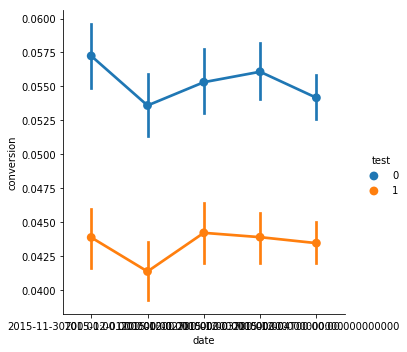

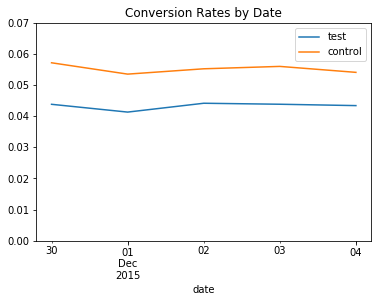

In [9]:
data["date"] = pd.to_datetime(data["date"], infer_datetime_format=True)

sns.catplot(x="date", y="conversion", hue="test", kind='point', data=data)



fig = data[data.test==1][
    ['date', 'conversion']].groupby('date').mean().plot()
data[data.test==0][
    ['date', 'conversion']].groupby('date').mean().plot(ax=fig)
plt.legend(['test','control'])
plt.title('Conversion Rates by Date')
plt.ylim(0,.07)
plt.show()

In [10]:
# Source: http://stackoverflow.com/questions/15204070/is-there-a-python-scipy-function-to-determine-parameters-needed-to-obtain-a-ta
# Input: p1: metric in control group
#        p2: metric in treatment group
#        power: represents the probability that you’ll get a false negative. A power of 0.80 means that there is an 80% chance that if there was an effect, we would detect it (or a 20% chance that we’d miss the effect)
#        sig: statistical significance of the test
# Output: Required sample size


def sample_power_probtest(p1, p2, power=0.95, sig=0.02):
    z = stats.norm.isf([sig/2]) #two-sided t test
    zp = -1 * stats.norm.isf([power]) 
    d = (p1-p2)
    s =2*((p1+p2) /2)*(1-((p1+p2) /2))
    n = s * ((zp + z)**2) / (d**2)
    return int(round(n[0]))

p1 = data[data['test']==1]['conversion'].mean()
p2 = data[data['test']==0]['conversion'].mean()
sample_power_probtest(p1, p2, power=0.8, sig=0.05)

5332

In [11]:
a = []
for date in data.date.unique():
    dated_data = data[data.date == date]
    b = (list(stats.ttest_ind(dated_data[dated_data.test == 0].conversion,
                          dated_data[dated_data.test == 1].conversion)))
    b[1] = "%.16f" % b[1]
    a.append(b)
    
a

[[8.781791368274808, '0.0000000000000000'],
 [9.29664238951323, '0.0000000000000000'],
 [8.096801163934462, '0.0000000000000006'],
 [7.626437343833345, '0.0000000000000244'],
 [6.752172953316423, '0.0000000000146770']]

In [12]:
data['test'].value_counts()

0    237093
1    215774
Name: test, dtype: int64